**Load Libraries**

In [1]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

**Creating Spark session**

In [3]:
spark = SparkSession.builder.appName("BigMart Sales").getOrCreate()
spark

your 131072x1 screen size is bogus. expect trouble
23/12/29 15:00:27 WARN Utils: Your hostname, NamThien resolves to a loopback address: 127.0.1.1; using 172.21.225.129 instead (on interface eth0)
23/12/29 15:00:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/29 15:00:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/12/29 15:00:30 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/12/29 15:00:30 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [4]:
sqlContext = spark.sparkContext
sqlContext

<SparkContext master=local[*] appName=BigMart Sales>

**Data Mining**

In [5]:
train = spark.read.option("delimiter", ",").option("header", "true").csv('./Train.csv', inferSchema=True)
test = spark.read.option("delimiter", ",").option("header", "true").csv('./Test.csv', inferSchema=True)

**Exploratory Data Analysis**

In [6]:
# Preview First 05 Rows of the Data
train.head(5)

[Row(Item_Identifier='FDA15', Item_Weight=9.3, Item_Fat_Content='Low Fat', Item_Visibility=0.016047301, Item_Type='Dairy', Item_MRP=249.8092, Outlet_Identifier='OUT049', Outlet_Establishment_Year=1999, Outlet_Size='Medium', Outlet_Location_Type='Tier 1', Outlet_Type='Supermarket Type1', Item_Outlet_Sales=3735.138),
 Row(Item_Identifier='DRC01', Item_Weight=5.92, Item_Fat_Content='Regular', Item_Visibility=0.019278216, Item_Type='Soft Drinks', Item_MRP=48.2692, Outlet_Identifier='OUT018', Outlet_Establishment_Year=2009, Outlet_Size='Medium', Outlet_Location_Type='Tier 3', Outlet_Type='Supermarket Type2', Item_Outlet_Sales=443.4228),
 Row(Item_Identifier='FDN15', Item_Weight=17.5, Item_Fat_Content='Low Fat', Item_Visibility=0.016760075, Item_Type='Meat', Item_MRP=141.618, Outlet_Identifier='OUT049', Outlet_Establishment_Year=1999, Outlet_Size='Medium', Outlet_Location_Type='Tier 1', Outlet_Type='Supermarket Type1', Item_Outlet_Sales=2097.27),
 Row(Item_Identifier='FDX07', Item_Weight=19.

In [7]:
# Check the data schemas
train.printSchema()

root
 |-- Item_Identifier: string (nullable = true)
 |-- Item_Weight: double (nullable = true)
 |-- Item_Fat_Content: string (nullable = true)
 |-- Item_Visibility: double (nullable = true)
 |-- Item_Type: string (nullable = true)
 |-- Item_MRP: double (nullable = true)
 |-- Outlet_Identifier: string (nullable = true)
 |-- Outlet_Establishment_Year: integer (nullable = true)
 |-- Outlet_Size: string (nullable = true)
 |-- Outlet_Location_Type: string (nullable = true)
 |-- Outlet_Type: string (nullable = true)
 |-- Item_Outlet_Sales: double (nullable = true)



Reloading data with schemas

In [8]:
from pyspark.sql.types import * 

train_schema = StructType([
               StructField('Item_Identifier', StringType(), True),
               StructField('Item_Weight', FloatType(), True),
               StructField('Item_Fat_Content', StringType(), True),
               StructField('Item_Visibility', FloatType(), True),
               StructField('Item_Type', StringType(), True),
               StructField('Item_MRP', FloatType(), True),
               StructField('Outlet_Identifier', StringType(), True),
               StructField('Outlet_Establishment_Year', IntegerType(), True),
               StructField('Outlet_Size', StringType(), True),
               StructField('Outlet_Location_Type', StringType(), True),
               StructField('Outlet_Type', StringType(), True),
               StructField('Item_Outlet_Sales', FloatType(), True),
              ])
test_schema = StructType([
               StructField('Item_Identifier', StringType(), True),
               StructField('Item_Weight', FloatType(), True),
               StructField('Item_Fat_Content', StringType(), True),
               StructField('Item_Visibility', FloatType(), True),
               StructField('Item_Type', StringType(), True),
               StructField('Item_MRP', FloatType(), True),
               StructField('Outlet_Identifier', StringType(), True),
               StructField('Outlet_Establishment_Year', IntegerType(), True),
               StructField('Outlet_Size', StringType(), True),
               StructField('Outlet_Location_Type', StringType(), True),
               StructField('Outlet_Type', StringType(), True),
              ])

In [9]:
train = spark.read.option("delimiter", ",").option("header", "true").csv('./Train.csv', schema = train_schema)
test =spark.read.option("delimiter", ",").option("header", "true").csv('./Test.csv', schema = test_schema)

In [10]:
train.show(5)

+---------------+-----------+----------------+---------------+--------------------+--------+-----------------+-------------------------+-----------+--------------------+-----------------+-----------------+
|Item_Identifier|Item_Weight|Item_Fat_Content|Item_Visibility|           Item_Type|Item_MRP|Outlet_Identifier|Outlet_Establishment_Year|Outlet_Size|Outlet_Location_Type|      Outlet_Type|Item_Outlet_Sales|
+---------------+-----------+----------------+---------------+--------------------+--------+-----------------+-------------------------+-----------+--------------------+-----------------+-----------------+
|          FDA15|        9.3|         Low Fat|      0.0160473|               Dairy|249.8092|           OUT049|                     1999|     Medium|              Tier 1|Supermarket Type1|         3735.138|
|          DRC01|       5.92|         Regular|    0.019278215|         Soft Drinks| 48.2692|           OUT018|                     2009|     Medium|              Tier 3|Superma

In [11]:
# show the dataframe columns
train.columns

['Item_Identifier',
 'Item_Weight',
 'Item_Fat_Content',
 'Item_Visibility',
 'Item_Type',
 'Item_MRP',
 'Outlet_Identifier',
 'Outlet_Establishment_Year',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type',
 'Item_Outlet_Sales']

We need to predict Item_Outlet_Sales for given test data

Lets first merge the train and test data for Exploratory Data Analysis


In [12]:
# Merge train, test with unionByName method
data = train.unionByName(test, allowMissingColumns=True);

# Convert train, test to pandas dataframe for data visualization
train_df = train.toPandas()
test_df = test.toPandas()

train_df['source'] = 'train'
test_df['source'] = 'test'
test_df['Item_Outlet_Sales'] = 0
data_df = pd.concat([train_df, test_df], sort = False)



In [13]:
data_df['Item_Outlet_Sales'].describe()

count    14204.000000
mean      1308.865490
std       1699.791423
min          0.000000
25%          0.000000
50%        559.271973
75%       2163.184082
max      13086.964844
Name: Item_Outlet_Sales, dtype: float64

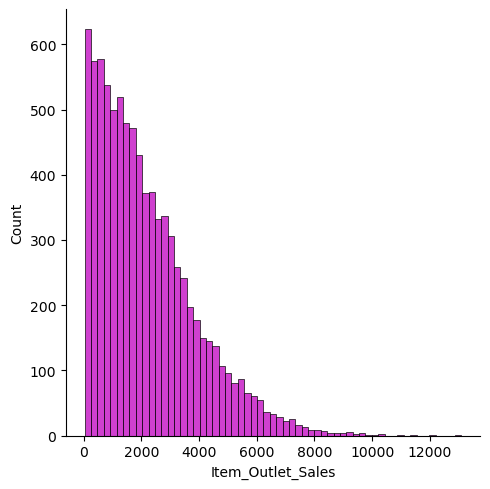

In [14]:
sns.displot(train_df.Item_Outlet_Sales, color = "m")
plt.show()

**Finding Missing values**

In [15]:
from pyspark.sql.functions import isnan, when, count, col

data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()


+---------------+-----------+----------------+---------------+---------+--------+-----------------+-------------------------+-----------+--------------------+-----------+-----------------+
|Item_Identifier|Item_Weight|Item_Fat_Content|Item_Visibility|Item_Type|Item_MRP|Outlet_Identifier|Outlet_Establishment_Year|Outlet_Size|Outlet_Location_Type|Outlet_Type|Item_Outlet_Sales|
+---------------+-----------+----------------+---------------+---------+--------+-----------------+-------------------------+-----------+--------------------+-----------+-----------------+
|              0|       2439|               0|              0|        0|       0|                0|                        0|       4016|                   0|          0|             5681|
+---------------+-----------+----------------+---------------+---------+--------+-----------------+-------------------------+-----------+--------------------+-----------+-----------------+



**Data Cleaning and Imputing Missing Values**

We found two variables with missing values – Item_Weight and Outlet_Size. The number 5681 missing values at Item_Outlet_Sales are due to the missing column in test data. We fill the missing values with zero value.

In [16]:
data = data.na.fill(0)
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()


+---------------+-----------+----------------+---------------+---------+--------+-----------------+-------------------------+-----------+--------------------+-----------+-----------------+
|Item_Identifier|Item_Weight|Item_Fat_Content|Item_Visibility|Item_Type|Item_MRP|Outlet_Identifier|Outlet_Establishment_Year|Outlet_Size|Outlet_Location_Type|Outlet_Type|Item_Outlet_Sales|
+---------------+-----------+----------------+---------------+---------+--------+-----------------+-------------------------+-----------+--------------------+-----------+-----------------+
|              0|          0|               0|              0|        0|       0|                0|                        0|       4016|                   0|          0|                0|
+---------------+-----------+----------------+---------------+---------+--------+-----------------+-------------------------+-----------+--------------------+-----------+-----------------+



In [17]:
data.show()

+---------------+-----------+----------------+---------------+--------------------+--------+-----------------+-------------------------+-----------+--------------------+-----------------+-----------------+
|Item_Identifier|Item_Weight|Item_Fat_Content|Item_Visibility|           Item_Type|Item_MRP|Outlet_Identifier|Outlet_Establishment_Year|Outlet_Size|Outlet_Location_Type|      Outlet_Type|Item_Outlet_Sales|
+---------------+-----------+----------------+---------------+--------------------+--------+-----------------+-------------------------+-----------+--------------------+-----------------+-----------------+
|          FDA15|        9.3|         Low Fat|      0.0160473|               Dairy|249.8092|           OUT049|                     1999|     Medium|              Tier 1|Supermarket Type1|         3735.138|
|          DRC01|       5.92|         Regular|    0.019278215|         Soft Drinks| 48.2692|           OUT018|                     2009|     Medium|              Tier 3|Superma

**Feature Extraction**

Now that we have re-ordered the data, we're ready to normalize the data. We will choose the features to be normalized.

In [18]:
featureCols = [ "Item_Weight", "Item_Visibility", "Item_MRP"]

**Use a VectorAssembler to put features into a feature vector column:**

In [19]:
# put features into a feature vector column
assembler = VectorAssembler(inputCols=featureCols, outputCol="features") 

In [20]:
assembled_df = assembler.transform(data)

In [21]:
assembled_df.show(10, truncate=False)

+---------------+-----------+----------------+---------------+---------------------+--------+-----------------+-------------------------+-----------+--------------------+-----------------+-----------------+-----------------------------------------------------------+
|Item_Identifier|Item_Weight|Item_Fat_Content|Item_Visibility|Item_Type            |Item_MRP|Outlet_Identifier|Outlet_Establishment_Year|Outlet_Size|Outlet_Location_Type|Outlet_Type      |Item_Outlet_Sales|features                                                   |
+---------------+-----------+----------------+---------------+---------------------+--------+-----------------+-------------------------+-----------+--------------------+-----------------+-----------------+-----------------------------------------------------------+
|FDA15          |9.3        |Low Fat         |0.0160473      |Dairy                |249.8092|OUT049           |1999                     |Medium     |Tier 1              |Supermarket Type1|3735.138   

**Standardization**

Next, we can finally scale the data using StandardScaler. The input columns are the features, and the output column with the rescaled that will be included in the scaled_df will be named "features_scaled":

In [22]:
# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")

In [23]:
# Fit the DataFrame to the scaler
scaled_df = standardScaler.fit(assembled_df).transform(assembled_df)

In [24]:
# Inspect the result
scaled_df.select("features", "features_scaled").show(10, truncate=False)

+-----------------------------------------------------------+-----------------------------------------------------------+
|features                                                   |features_scaled                                            |
+-----------------------------------------------------------+-----------------------------------------------------------+
|[9.300000190734863,0.016047300770878792,249.8092041015625] |[1.448767029079376,0.31184879221481754,4.023538806448005]  |
|[5.920000076293945,0.019278215244412422,48.26919937133789] |[0.9222258867506914,0.3746354745800699,0.7774453208209028] |
|[17.5,0.016760075464844704,141.6179962158203]              |[2.7261744611733945,0.3257002137472117,2.28096280725549]   |
|[19.200000762939453,0.0,182.09500122070312]                |[2.9910029562534413,0.0,2.932903559365342]                 |
|[8.930000305175781,0.0,53.86140060424805]                  |[1.3911279297280474,0.0,0.8675158158413049]                |
|[10.395000457763672,0.0

**Building A Machine Learning Model With Spark ML**

With all the preprocessing done, it's finally time to start building our Linear Regression model. We first need to split the data into training and test sets. Luckily, this is no issue with the randomSplit() method:

In [25]:
# Split the data into train and test sets
train_data, test_data = scaled_df.randomSplit([.8,.2], seed=rnd_seed)

In [26]:
train_data.columns

['Item_Identifier',
 'Item_Weight',
 'Item_Fat_Content',
 'Item_Visibility',
 'Item_Type',
 'Item_MRP',
 'Outlet_Identifier',
 'Outlet_Establishment_Year',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type',
 'Item_Outlet_Sales',
 'features',
 'features_scaled']

In [27]:
# Initialize `lr`
lr = (LinearRegression(featuresCol='features_scaled', labelCol="Item_Outlet_Sales", predictionCol='Item_Outlet_Sales_pred', 
                               maxIter=10, regParam=0.3, elasticNetParam=0.8, standardization=False))

In [28]:
# Fit the data to the model
linearModel = lr.fit(train_data)

23/12/29 15:01:35 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


**Evaluating the Model**

Inspect the Model Co-efficients

In [29]:
# Coefficients for the model
linearModel.coefficients

DenseVector([-62.6556, -126.398, 582.2214])

In [30]:
# Intercept for the model
linearModel.intercept

244.18496438561314

In [31]:
coeff_df = pd.DataFrame({"Feature": ["Intercept"] + featureCols, "Co-efficients": np.insert(linearModel.coefficients.toArray(), 0, linearModel.intercept)})
coeff_df = coeff_df[["Feature", "Co-efficients"]]

In [32]:
coeff_df

,Feature,Co-efficients
0,Intercept,244.184964
1,Item_Weight,-62.655551
2,Item_Visibility,-126.397997
3,Item_MRP,582.221420


In [ ]:
# Save the model
model_path = "./linear_regression_model"
linearModel.save(model_path)

**Generating Predictions**

In [39]:
# Generate predictions
predictions = linearModel.transform(test_data)

In [40]:
# Extract the predictions and the "known" correct labels
predandlabels = predictions.select("Item_Outlet_Sales_pred", "Item_Outlet_Sales")

In [41]:
predandlabels.show()

+----------------------+-----------------+
|Item_Outlet_Sales_pred|Item_Outlet_Sales|
+----------------------+-----------------+
|    1461.7767200003798|         992.7078|
|     1603.691750138782|         491.3604|
|    1481.0466520080176|        4422.2437|
|    1501.0407873819765|        1146.5076|
|    1730.3926243475078|         1518.024|
|    1959.6389943930276|         3415.554|
|    1928.3853144409145|          948.765|
|     960.5757398439945|        2358.2637|
|     561.1799299414885|        1296.3126|
|    362.82537622981636|         157.1288|
|     591.6945382583176|         443.4228|
|     1312.993238033144|          739.038|
|    1445.2792837808677|        3383.5957|
|      877.085239092132|         1288.323|
|    1763.1491028822225|         5778.478|
|    1366.2213240164717|        2444.8176|
|     506.2503241409388|          828.921|
|    507.48525870455694|        1049.9666|
|    1082.6720137001998|        2645.2234|
|     856.2311699799947|        1733.0774|
+----------